In [1]:
# smt-layerの追加

# Actor-Critic for Grid-World

## smt-layerのimport
import sys
from pathlib import Path
import os
sys.path.append(os.path.abspath(os.path.join(Path().resolve(), '..')))

## 必要なライブラリをインポートします
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import namedtuple, deque
import random
import matplotlib.pyplot as plt

import z3
from smtlayer import SMTLayer


In [2]:

## 環境の設定
class GridWorld:
    def __init__(self, size=4, pitfall_positions=None):
        self.size = size
        self.state = np.zeros((size, size))
        self.state[0, 0] = 1
        self.done = False
        self.pos = [0, 0]
        self.goal = [size-1, size-1]
        # 落とし穴の位置をリストで指定（デフォルトはなし）
        self.pitfall_positions = pitfall_positions if pitfall_positions else []

    def reset(self):
        self.state = np.zeros((self.size, self.size))
        self.state[0, 0] = 1
        self.done = False
        self.pos = [0, 0]
        return self.state.flatten()

    def step(self, action):
        if self.done:
            raise ValueError("Game is done")
        
        if action == 0 and self.pos[1] > 0:   # Left
            self.pos[1] -= 1
        elif action == 1 and self.pos[1] < self.size - 1:  # Right
            self.pos[1] += 1
        elif action == 2 and self.pos[0] > 0:  # Up
            self.pos[0] -= 1
        elif action == 3 and self.pos[0] < self.size - 1:  # Down
            self.pos[0] += 1
        
        self.state = np.zeros((self.size, self.size))
        self.state[self.pos[0], self.pos[1]] = 1
        
        # 報酬設計
        reward = -1
        if self.pos == self.goal:
            reward = 100
            self.done = True
        elif self.pos in self.pitfall_positions:
            reward = -200  # 落とし穴に落ちた場合、大きなペナルティ
            self.done = True
        
        return self.state.flatten(), reward, self.done

## Actor-Criticモデルの定義
class ActorCriticWithSat(nn.Module):
    def __init__(self, state_size, grid_size, action_size, hidden_size=64, use_maxsmt=False):
        super(ActorCriticWithSat, self).__init__()
        self.grid_size = grid_size
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc_actor = nn.Linear(hidden_size, action_size)
        self.fc_critic = nn.Linear(hidden_size, 1)

        # 制約の追加
        inputs = z3.Bools('v0 v1 v2 v3 v4 v5 v6 v7')
        outputs = z3.Bools('v8 v9 v10 v11')
        x0, x1, x2, x3, x4, x5, x6, x7 = inputs
        y0, y1, y2, y3 = outputs
        z1, z2, y = z3.BitVecs('z1 z2 y', 4)
        # z1にx0-3(feature)を代入
        cl9 = z1 == z3.Concat(z3.If(x0, z3.BitVecVal(1, 1), z3.BitVecVal(0, 1)),
                              z3.If(x1, z3.BitVecVal(1, 1), z3.BitVecVal(0, 1)),
                              z3.If(x2, z3.BitVecVal(1, 1), z3.BitVecVal(0, 1)),
                              z3.If(x3, z3.BitVecVal(1, 1), z3.BitVecVal(0, 1)))
        # z2にx4-7(allowed_direction)を代入
        cl10 = z2 == z3.Concat(z3.If(x4, z3.BitVecVal(1, 1), z3.BitVecVal(0, 1)),
                               z3.If(x5, z3.BitVecVal(1, 1), z3.BitVecVal(0, 1)),
                               z3.If(x6, z3.BitVecVal(1, 1), z3.BitVecVal(0, 1)),
                               z3.If(x7, z3.BitVecVal(1, 1), z3.BitVecVal(0, 1)))
        cl11 = y == (z1 & z2)
        cl12 = y0 == (z3.Extract(0, 0, y) == z3.BitVecVal(1, 1))
        cl13 = y1 == (z3.Extract(1, 1, y) == z3.BitVecVal(1, 1))
        cl14 = y2 == (z3.Extract(2, 2, y) == z3.BitVecVal(1, 1))
        cl15 = y3 == (z3.Extract(3, 3, y) == z3.BitVecVal(1, 1))

        # y0, y1, y2, y3のどれか一つだけが1である制約
        # cl16 = z3.PbEq([(y0, 1), (y1, 1), (y2, 1), (y3, 1)], 1)

        clauses = [cl9,cl10,cl11,cl12,cl13,cl14,cl15]
        mask = torch.tensor([1.,1.,1.,1.,1.,1.,1.,1.,0.,0.,0.,0.])
        
        self.sat = SMTLayer(
            input_size=8,
            output_size=4,
            variables=inputs+outputs,
            theory=clauses,
            default_mask=mask,
            solverop='smt' if not use_maxsmt else 'maxsmt')
    
    def forward(self, x, pos, return_sat=True, do_maxsat=False ):
        x = F.relu(self.fc1(x))
        actor_output = self.fc_actor(x) #dim=4


        # actor
        if return_sat:
            pads = torch.zeros((actor_output.shape[0], 4), dtype=actor_output.dtype, device=actor_output.device)
            allowed_direction = self.allowed_direction(pos)
            # allowed_direction をバッチサイズだけ拡張
            allowed_direction = allowed_direction.unsqueeze(0).repeat(actor_output.shape[0], 1) # dim=4 -> dim=(batch_size, 4)
            combined = torch.cat([actor_output, allowed_direction], dim=1) # dim=8
            combined = torch.cat([combined, pads], dim=1) # dim=12
            actor_output = self.sat(combined, do_maxsat_forward=True)
        actor_output = F.softmax(actor_output, dim=-1)

        critic_output = self.fc_critic(x)
        return actor_output, critic_output
    
    def allowed_direction(self, pos):
        x = pos[0]
        y = pos[1]
        width = self.grid_size
        height = self.grid_size
        allowed_direction = torch.zeros(4)  # [左, 上, 下, 右] の順で初期化
        if x == 0:
            allowed_direction[0] = -1 # 左
        if y == 0: 
            allowed_direction[1] = -1 # 上
        if y == height - 1: 
            allowed_direction[2] = -1 # 下
        if x == width - 1:
            allowed_direction[3] = -1 # 右

        return allowed_direction

## エージェントの定義
class Agent:
    def __init__(self, state_size, grid_size, action_size, gamma=0.99, lr=0.001, epsilon=0.1):
        self.actor_critic = ActorCriticWithSat(state_size, grid_size, action_size)
        # self.actor_critic = ActorCriticWithSat(state_size, grid_size, action_size, use_maxsmt=True)
        self.optimizer = optim.Adam(self.actor_critic.parameters(), lr=lr)
        self.gamma = gamma
        self.epsilon = epsilon
        self.action_size = action_size
    
    def select_action(self, state, pos, deterministic=False):
        state = torch.from_numpy(state).float().unsqueeze(0)
        probs, _ = self.actor_critic(state, pos)
        
        if deterministic:
            action = torch.argmax(probs).item()  # 最も高い確率の行動を選択
        else:
            if random.random() > self.epsilon:
                action = torch.argmax(probs).item()  # 最も高い確率の行動を選択
            else:
                action = random.choice(range(self.action_size))  # ランダムに行動を選択
            
        log_prob = torch.log(probs.squeeze(0)[action])
        return action, log_prob

    def update(self, log_probs, values, rewards, next_value, dones):
        Qvals = np.zeros(len(rewards))
        Qval = next_value
        
        for t in reversed(range(len(rewards))):
            Qval = rewards[t] + self.gamma * Qval * (1 - dones[t])
            Qvals[t] = Qval
        
        Qvals = torch.tensor(Qvals)
        values = torch.stack(values)
        log_probs = torch.stack(log_probs)

        advantage = Qvals - values
        
        actor_loss = (-log_probs * advantage.detach()).mean()
        critic_loss = advantage.pow(2).mean()

        loss = actor_loss + critic_loss
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()




# 落とし穴なし

In [4]:

## 落とし穴を含む環境とエージェントの設定
# 落とし穴の位置を指定（例として[1, 1]と[2, 2]に設置）
pitfall_positions = [[1, 1], [2, 2]]
# env = GridWorld(size=4, pitfall_positions=pitfall_positions)
env = GridWorld(size=4, pitfall_positions=None)

state_size = env.size * env.size
action_size = 4
agent = Agent(state_size, env.size, action_size)

## 訓練
n_episodes = 1000
max_t = 100
scores = []
actor_losses = []
critic_losses = []
Q_values = []

for i_episode in range(1, n_episodes+1):
    state = env.reset()
    log_probs = []
    values = []
    rewards = []
    dones = []
    
    for t in range(max_t):
        action, log_prob = agent.select_action(state, env.pos)
        next_state, reward, done = env.step(action)
        
        log_probs.append(log_prob)
        values.append(agent.actor_critic(torch.from_numpy(state).float().unsqueeze(0), tuple(env.pos))[1])
        rewards.append(reward)
        dones.append(done)
        
        state = next_state
        
        if done:
            break

    next_value = agent.actor_critic(torch.from_numpy(state).float().unsqueeze(0), tuple(env.pos))[1].detach()
    
    # エージェントの更新
    def calc_qval():
        Qval = np.zeros(len(rewards))
        Qval[-1] = rewards[-1] + agent.gamma * next_value * (1 - dones[-1])
        
        for t in reversed(range(len(rewards)-1)):
            Qval[t] = rewards[t] + agent.gamma * Qval[t+1] * (1 - dones[t])
        
        Q_values.append(Qval.mean().item())
        return Qval
    Qval = torch.tensor(calc_qval())
    values = torch.stack(values)
    log_probs = torch.stack(log_probs)

    advantage = Qval - values

    actor_loss = (-log_probs * advantage.detach()).mean()
    critic_loss = advantage.pow(2).mean()

    loss = actor_loss + critic_loss
    
    actor_losses.append(actor_loss.item())
    critic_losses.append(critic_loss.item())

    agent.optimizer.zero_grad()
    loss.backward()
    agent.optimizer.step()
    
    scores.append(sum(rewards))
    
    if i_episode % 100 == 0:
        print(f"Episode {i_episode}/{n_episodes}, Average Score: {np.mean(scores[-100:])}")


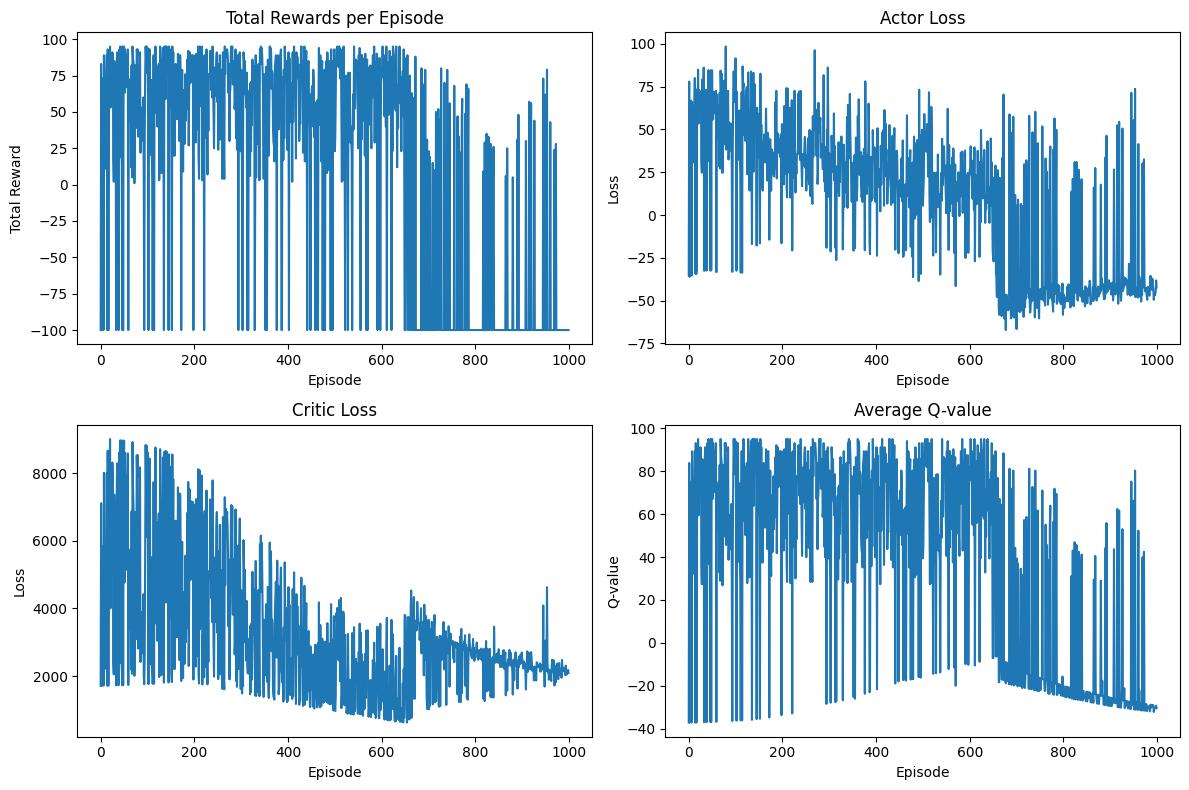

In [4]:

## グラフの表示
plt.figure(figsize=(12, 8))

# 報酬のグラフ
plt.subplot(2, 2, 1)
plt.plot(scores)
plt.title('Total Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

# アクター損失のグラフ
plt.subplot(2, 2, 2)
plt.plot(actor_losses)
plt.title('Actor Loss')
plt.xlabel('Episode')
plt.ylabel('Loss')

# クリティック損失のグラフ
plt.subplot(2, 2, 3)
plt.plot(critic_losses)
plt.title('Critic Loss')
plt.xlabel('Episode')
plt.ylabel('Loss')

# Q値のグラフ
plt.subplot(2, 2, 4)
plt.plot(Q_values)
plt.title('Average Q-value')
plt.xlabel('Episode')
plt.ylabel('Q-value')

plt.tight_layout()
plt.show()


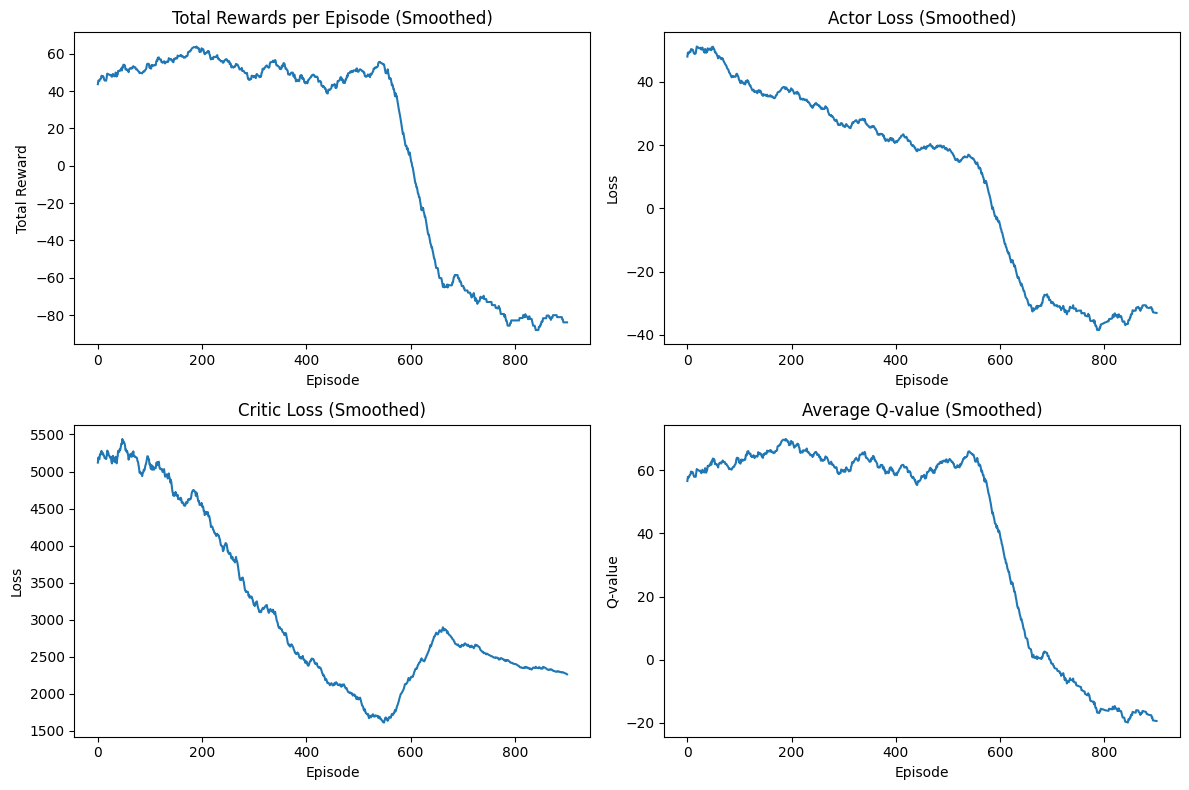

In [5]:
## 移動平均を計算する関数
def moving_average(data, window_size=10):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

## グラフの表示
import matplotlib.pyplot as plt

# 移動平均のウィンドウサイズを指定
window_size = 100

plt.figure(figsize=(12, 8))

# 報酬のグラフ
plt.subplot(2, 2, 1)
smoothed_scores = moving_average(scores, window_size)
plt.plot(smoothed_scores)
plt.title('Total Rewards per Episode (Smoothed)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

# アクター損失のグラフ
plt.subplot(2, 2, 2)
smoothed_actor_losses = moving_average(actor_losses, window_size)
plt.plot(smoothed_actor_losses)
plt.title('Actor Loss (Smoothed)')
plt.xlabel('Episode')
plt.ylabel('Loss')

# クリティック損失のグラフ
plt.subplot(2, 2, 3)
smoothed_critic_losses = moving_average(critic_losses, window_size)
plt.plot(smoothed_critic_losses)
plt.title('Critic Loss (Smoothed)')
plt.xlabel('Episode')
plt.ylabel('Loss')

# Q値のグラフ
plt.subplot(2, 2, 4)
smoothed_Q_values = moving_average(Q_values, window_size)
plt.plot(smoothed_Q_values)
plt.title('Average Q-value (Smoothed)')
plt.xlabel('Episode')
plt.ylabel('Q-value')

plt.tight_layout()
plt.show()


In [6]:

## 方策を可視化する関数
def get_policy(agent, env):
    policy = np.zeros((env.size, env.size), dtype=int)
    for i in range(env.size):
        for j in range(env.size):
            state = np.zeros((env.size, env.size))
            state[i, j] = 1
            state = state.flatten()
            action, _ = agent.select_action(state, env.pos, deterministic=True)  # 確定的に行動選択
            policy[i, j] = action
    return policy

def plot_policy(policy, env):
    direction = {0: '<', 1: '>', 2: '^', 3: 'v'}
    policy_grid = np.vectorize(direction.get)(policy)
    for i in range(env.size):
        for j in range(env.size):
            if [i, j] == env.goal:
                policy_grid[i, j] = 'G'
            elif [i, j] in env.pitfall_positions:
                policy_grid[i, j] = 'X'  # 落とし穴の位置を表示
    print(policy_grid)

# 学習後のエージェントの方策を可視化
policy = get_policy(agent, env)
plot_policy(policy, env)


[['<' '>' '>' '<']
 ['<' '<' 'v' '>']
 ['<' '<' '<' '<']
 ['<' '<' '>' 'G']]


In [7]:
## エピソードを走らせたときの経路を可視化する関数

def visualize_deterministic_episode(agent, env):
    state = env.reset()
    done = False
    path = []
    path.append(env.pos.copy())
    max_t = 100

    for t in range(max_t):
        action, _ = agent.select_action(state, env.pos, deterministic=False)  # 確定的に行動選択
        state, _, done = env.step(action)
        path.append(env.pos.copy())
    
    return path

def plot_path(path, env):
    grid = np.zeros((env.size, env.size), dtype=str)
    grid[:] = '-'
    
    for position in path:
        grid[position[0], position[1]] = 'o'
    
    # 落とし穴とゴールの位置を設定
    for pitfall in env.pitfall_positions:
        grid[pitfall[0], pitfall[1]] = 'X'
    
    grid[env.goal[0], env.goal[1]] = 'G'
    
    # スタート地点を表示
    grid[0, 0] = 'S'
    
    print(grid)

## 確定的なエピソードを実行して経路を可視化
path = visualize_deterministic_episode(agent, env)
plot_path(path, env)


[['S' 'o' 'o' 'o']
 ['-' '-' 'o' 'o']
 ['-' '-' '-' '-']
 ['-' '-' '-' 'G']]


# 落とし穴あり

In [8]:

## 落とし穴を含む環境とエージェントの設定
# 落とし穴の位置を指定（例として[1, 1]と[2, 2]に設置）
pitfall_positions = [[2, 2]] # 落とし穴の位置を指定
# pitfall_positions = [[1,1],[2,2]]  # 落とし穴を2つ設置するとうまく学習できない
env = GridWorld(size=4, pitfall_positions=pitfall_positions)

state_size = env.size * env.size
action_size = 4
agent = Agent(state_size, action_size)

## 訓練
n_episodes = 5000
max_t = 100
scores = []
actor_losses = []
critic_losses = []
Q_values = []

for i_episode in range(1, n_episodes+1):
    state = env.reset()
    log_probs = []
    values = []
    rewards = []
    dones = []
    
    for t in range(max_t):
        action, log_prob = agent.select_action(state)
        next_state, reward, done = env.step(action)
        
        log_probs.append(log_prob)
        values.append(agent.actor_critic(torch.from_numpy(state).float().unsqueeze(0))[1])
        rewards.append(reward)
        dones.append(done)
        
        state = next_state
        
        if done:
            break

    next_value = agent.actor_critic(torch.from_numpy(state).float().unsqueeze(0))[1].detach()
    
    # エージェントの更新
    Qval = np.zeros(len(rewards))
    Qval[-1] = rewards[-1] + agent.gamma * next_value * (1 - dones[-1])
    
    for t in reversed(range(len(rewards)-1)):
        Qval[t] = rewards[t] + agent.gamma * Qval[t+1] * (1 - dones[t])
    
    Q_values.append(Qval.mean().item())
    
    Qval = torch.tensor(Qval)
    values = torch.stack(values)
    log_probs = torch.stack(log_probs)

    advantage = Qval - values

    actor_loss = (-log_probs * advantage.detach()).mean()
    critic_loss = advantage.pow(2).mean()

    loss = actor_loss + critic_loss
    
    actor_losses.append(actor_loss.item())
    critic_losses.append(critic_loss.item())

    agent.optimizer.zero_grad()
    loss.backward()
    agent.optimizer.step()
    
    scores.append(sum(rewards))
    
    if i_episode % 100 == 0:
        print(f"Episode {i_episode}/{n_episodes}, Average Score: {np.mean(scores[-100:])}")


TypeError: Agent.__init__() missing 1 required positional argument: 'action_size'

In [ ]:

## グラフの表示
plt.figure(figsize=(12, 8))

# 報酬のグラフ
plt.subplot(2, 2, 1)
plt.plot(scores)
plt.title('Total Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

# アクター損失のグラフ
plt.subplot(2, 2, 2)
plt.plot(actor_losses)
plt.title('Actor Loss')
plt.xlabel('Episode')
plt.ylabel('Loss')

# クリティック損失のグラフ
plt.subplot(2, 2, 3)
plt.plot(critic_losses)
plt.title('Critic Loss')
plt.xlabel('Episode')
plt.ylabel('Loss')

# Q値のグラフ
plt.subplot(2, 2, 4)
plt.plot(Q_values)
plt.title('Average Q-value')
plt.xlabel('Episode')
plt.ylabel('Q-value')

plt.tight_layout()
plt.show()


In [ ]:
## 移動平均を計算する関数
def moving_average(data, window_size=10):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

## グラフの表示
import matplotlib.pyplot as plt

# 移動平均のウィンドウサイズを指定
window_size = 500

plt.figure(figsize=(12, 8))

# 報酬のグラフ
plt.subplot(2, 2, 1)
smoothed_scores = moving_average(scores, window_size)
plt.plot(smoothed_scores)
plt.title('Total Rewards per Episode (Smoothed)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

# アクター損失のグラフ
plt.subplot(2, 2, 2)
smoothed_actor_losses = moving_average(actor_losses, window_size)
plt.plot(smoothed_actor_losses)
plt.title('Actor Loss (Smoothed)')
plt.xlabel('Episode')
plt.ylabel('Loss')

# クリティック損失のグラフ
plt.subplot(2, 2, 3)
smoothed_critic_losses = moving_average(critic_losses, window_size)
plt.plot(smoothed_critic_losses)
plt.title('Critic Loss (Smoothed)')
plt.xlabel('Episode')
plt.ylabel('Loss')

# Q値のグラフ
plt.subplot(2, 2, 4)
smoothed_Q_values = moving_average(Q_values, window_size)
plt.plot(smoothed_Q_values)
plt.title('Average Q-value (Smoothed)')
plt.xlabel('Episode')
plt.ylabel('Q-value')

plt.tight_layout()
plt.show()


In [ ]:

## 方策を可視化する関数
def get_policy(agent, env):
    policy = np.zeros((env.size, env.size), dtype=int)
    for i in range(env.size):
        for j in range(env.size):
            state = np.zeros((env.size, env.size))
            state[i, j] = 1
            state = state.flatten()
            action, _ = agent.select_action(state, deterministic=True)  # 確定的に行動選択
            policy[i, j] = action
    return policy

def plot_policy(policy, env):
    direction = {0: '<', 1: '>', 2: '^', 3: 'v'}
    policy_grid = np.vectorize(direction.get)(policy)
    for i in range(env.size):
        for j in range(env.size):
            if [i, j] == env.goal:
                policy_grid[i, j] = 'G'
            elif [i, j] in env.pitfall_positions:
                policy_grid[i, j] = 'X'  # 落とし穴の位置を表示
    print(policy_grid)

# 学習後のエージェントの方策を可視化
policy = get_policy(agent, env)
plot_policy(policy, env)


In [ ]:
## エピソードを走らせたときの経路を可視化する関数

def visualize_deterministic_episode(agent, env):
    state = env.reset()
    done = False
    path = []
    path.append(env.pos.copy())
    
    while not done:
        action, _ = agent.select_action(state, deterministic=False)  # 確定的に行動選択
        state, _, done = env.step(action)
        path.append(env.pos.copy())
    
    return path

def plot_path(path, env):
    grid = np.zeros((env.size, env.size), dtype=str)
    grid[:] = '-'
    
    for position in path:
        grid[position[0], position[1]] = 'o'
    
    # 落とし穴とゴールの位置を設定
    for pitfall in env.pitfall_positions:
        grid[pitfall[0], pitfall[1]] = 'X'
    
    grid[env.goal[0], env.goal[1]] = 'G'
    
    # スタート地点を表示
    grid[0, 0] = 'S'
    
    print(grid)

## 確定的なエピソードを実行して経路を可視化
path = visualize_deterministic_episode(agent, env)
plot_path(path, env)


# 落とし穴2つ

In [ ]:

## 落とし穴を含む環境とエージェントの設定
# 落とし穴の位置を指定（例として[1, 1]と[2, 2]に設置）
# pitfall_positions = [[2, 2]] # 落とし穴の位置を指定
pitfall_positions = [[1,1],[2,2]]  # 落とし穴を2つ設置するとうまく学習できない
env = GridWorld(size=4, pitfall_positions=pitfall_positions)

state_size = env.size * env.size
action_size = 4
agent = Agent(state_size, action_size)

## 訓練
n_episodes = 2000
max_t = 100
scores = []
actor_losses = []
critic_losses = []
Q_values = []

for i_episode in range(1, n_episodes+1):
    state = env.reset()
    log_probs = []
    values = []
    rewards = []
    dones = []
    
    for t in range(max_t):
        action, log_prob = agent.select_action(state)
        next_state, reward, done = env.step(action)
        
        log_probs.append(log_prob)
        values.append(agent.actor_critic(torch.from_numpy(state).float().unsqueeze(0))[1])
        rewards.append(reward)
        dones.append(done)
        
        state = next_state
        
        if done:
            break

    next_value = agent.actor_critic(torch.from_numpy(state).float().unsqueeze(0))[1].detach()
    
    # エージェントの更新
    Qval = np.zeros(len(rewards))
    Qval[-1] = rewards[-1] + agent.gamma * next_value * (1 - dones[-1])
    
    for t in reversed(range(len(rewards)-1)):
        Qval[t] = rewards[t] + agent.gamma * Qval[t+1] * (1 - dones[t])
    
    Q_values.append(Qval.mean().item())
    
    Qval = torch.tensor(Qval)
    values = torch.stack(values)
    log_probs = torch.stack(log_probs)

    advantage = Qval - values

    actor_loss = (-log_probs * advantage.detach()).mean()
    critic_loss = advantage.pow(2).mean()

    loss = actor_loss + critic_loss
    
    actor_losses.append(actor_loss.item())
    critic_losses.append(critic_loss.item())

    agent.optimizer.zero_grad()
    loss.backward()
    agent.optimizer.step()
    
    scores.append(sum(rewards))
    
    if i_episode % 100 == 0:
        print(f"Episode {i_episode}/{n_episodes}, Average Score: {np.mean(scores[-100:])}")


In [ ]:

## グラフの表示
plt.figure(figsize=(12, 8))

# 報酬のグラフ
plt.subplot(2, 2, 1)
plt.plot(scores)
plt.title('Total Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

# アクター損失のグラフ
plt.subplot(2, 2, 2)
plt.plot(actor_losses)
plt.title('Actor Loss')
plt.xlabel('Episode')
plt.ylabel('Loss')

# クリティック損失のグラフ
plt.subplot(2, 2, 3)
plt.plot(critic_losses)
plt.title('Critic Loss')
plt.xlabel('Episode')
plt.ylabel('Loss')

# Q値のグラフ
plt.subplot(2, 2, 4)
plt.plot(Q_values)
plt.title('Average Q-value')
plt.xlabel('Episode')
plt.ylabel('Q-value')

plt.tight_layout()
plt.show()


In [ ]:
## 移動平均を計算する関数
def moving_average(data, window_size=10):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

## グラフの表示
import matplotlib.pyplot as plt

# 移動平均のウィンドウサイズを指定
window_size = 500

plt.figure(figsize=(12, 8))

# 報酬のグラフ
plt.subplot(2, 2, 1)
smoothed_scores = moving_average(scores, window_size)
plt.plot(smoothed_scores)
plt.title('Total Rewards per Episode (Smoothed)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

# アクター損失のグラフ
plt.subplot(2, 2, 2)
smoothed_actor_losses = moving_average(actor_losses, window_size)
plt.plot(smoothed_actor_losses)
plt.title('Actor Loss (Smoothed)')
plt.xlabel('Episode')
plt.ylabel('Loss')

# クリティック損失のグラフ
plt.subplot(2, 2, 3)
smoothed_critic_losses = moving_average(critic_losses, window_size)
plt.plot(smoothed_critic_losses)
plt.title('Critic Loss (Smoothed)')
plt.xlabel('Episode')
plt.ylabel('Loss')

# Q値のグラフ
plt.subplot(2, 2, 4)
smoothed_Q_values = moving_average(Q_values, window_size)
plt.plot(smoothed_Q_values)
plt.title('Average Q-value (Smoothed)')
plt.xlabel('Episode')
plt.ylabel('Q-value')

plt.tight_layout()
plt.show()


In [ ]:

## 方策を可視化する関数
def get_policy(agent, env):
    policy = np.zeros((env.size, env.size), dtype=int)
    for i in range(env.size):
        for j in range(env.size):
            state = np.zeros((env.size, env.size))
            state[i, j] = 1
            state = state.flatten()
            action, _ = agent.select_action(state, deterministic=True)  # 確定的に行動選択
            policy[i, j] = action
    return policy

def plot_policy(policy, env):
    direction = {0: '<', 1: '>', 2: '^', 3: 'v'}
    policy_grid = np.vectorize(direction.get)(policy)
    for i in range(env.size):
        for j in range(env.size):
            if [i, j] == env.goal:
                policy_grid[i, j] = 'G'
            elif [i, j] in env.pitfall_positions:
                policy_grid[i, j] = 'X'  # 落とし穴の位置を表示
    print(policy_grid)

# 学習後のエージェントの方策を可視化
policy = get_policy(agent, env)
plot_policy(policy, env)


In [ ]:
## エピソードを走らせたときの経路を可視化する関数

def visualize_deterministic_episode(agent, env):
    state = env.reset()
    done = False
    path = []
    path.append(env.pos.copy())
    
    while not done:
        action, _ = agent.select_action(state, deterministic=False)  # 確定的に行動選択
        state, _, done = env.step(action)
        path.append(env.pos.copy())
    
    return path

def plot_path(path, env):
    grid = np.zeros((env.size, env.size), dtype=str)
    grid[:] = '-'
    
    for position in path:
        grid[position[0], position[1]] = 'o'
    
    # 落とし穴とゴールの位置を設定
    for pitfall in env.pitfall_positions:
        grid[pitfall[0], pitfall[1]] = 'X'
    
    grid[env.goal[0], env.goal[1]] = 'G'
    
    # スタート地点を表示
    grid[0, 0] = 'S'
    
    print(grid)

## 確定的なエピソードを実行して経路を可視化
path = visualize_deterministic_episode(agent, env)
plot_path(path, env)
